# Predict e-commerce returns
*Christos Kestritsalis*

## Outline

1. Introduction
2. EDA
    - 2.1. Import relevant libraries and known dataset
    - 2.2 First glance at known dataset
    - 2.3 Closer look on data types
    - 2.4 Summary statistics
    - 2.5 First visual exploration
3. Data Prep
    - 3.1 Change data types
    - 3.2 Handle empty/nulls
    - 3.3 Handle outliers
    - 3.4 Feature recategorization
    - 3.5 Feature creation
    - 3.6 Feature normalization
    - 3.7 Category encoding (One-hot encoding)
4. Model tuning and selection
    - 4.1 Define list of features
    - 4.2 Define dependent and independent features
    - 4.3 Split sample
    - 4.4 Logistic Regression
    - 4.5 Decision Tree
    - 4.6 Random Forest
    - 4.7 Support Vector Machine
5. Model evaluation
    - 5.1 ROC Curve - AUC
    - 5.2 Create predictions for unknown dataset
    - 5.3 Create output file

6. Conclusion

---

## 1. Introduction

Returns has become an important factor of e-commerce shops and can result in significant costs in case customers return a lot of orders. Purpose of the assignment is to find a model that minimizes the expected costs by preventing orders that are likely to result in a return.

In order to successfully **minimize the expected costs** from the returns,  different classification models are to be tested. In the end, the most effective one will be selected and used to create prediction on unknown dataset.

- First, given data set is explored to get a first sense of what the characteristics of the data are.

- Then data is to be cleaned and transformed ,in order to remove empty or null values, normalize outliers and bringthe data in a form that will help apply a classification model later (Data Prep)

- Next, different models are tested for predictive performance: logistic regression, decision trees, random forest & support vector machine (Model tuning and selection)

- Next, selected model is evaluated using ROC Curve & AUC criteria (Model evaluation)

- The conclusions of the analysis are discussed in the closing section (Conclusion)

---

## 2. Exploratory Data Analysis

### 2.1 Import relevant libraries and known dataset

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,6)

df_known = pd.read_csv("BADS_WS2021_known.csv", index_col = 'order_item_id')

### 2.2. First glance at known dataset

In [2]:
df_known.head()

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
1,22-06-16,27-06-16,643,38,navy,30,49.90,30822,Mrs,17-04-69,Saxony,23-06-16,0
2,22-06-16,NaN,337,152,grey,30,19.95,30822,Mrs,17-04-69,Saxony,23-06-16,0
3,22-06-16,27-06-16,270,xxl,grey,49,79.90,30823,Mrs,22-04-70,Baden-Wuerttemberg,15-03-15,1
4,22-06-16,27-06-16,142,xxl,grey,49,99.90,30823,Mrs,22-04-70,Baden-Wuerttemberg,15-03-15,0
5,22-06-16,27-06-16,561,xxl,grey,3,14.90,30823,Mrs,22-04-70,Baden-Wuerttemberg,15-03-15,1


Conclusions about dataset at this point:

- Number of features: 14
- Number of observations: 100,000
- 1 index column: order_item_id
- 4 date columns: order_date, delivery_date, user_dob, user_reg_date
- 5 numerical columns: item_id, brand_id, item_price, user_id, return
- 4 categorical columns: item size, item_color, user_title, user_state

We also notice an imlicit separation in the columns:
- Cols 1-8 are related to item
- Cols 9-13 are related to user
- Col 14 indicates whether order was returned

### 2.3 Closer look on data types

In [3]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 13 columns):
order_date       100000 non-null object
delivery_date    90682 non-null object
item_id          100000 non-null int64
item_size        100000 non-null object
item_color       100000 non-null object
brand_id         100000 non-null int64
item_price       100000 non-null float64
user_id          100000 non-null int64
user_title       100000 non-null object
user_dob         91275 non-null object
user_state       100000 non-null object
user_reg_date    100000 non-null object
return           100000 non-null int64
dtypes: float64(1), int64(4), object(8)
memory usage: 10.7+ MB


Observations regarding data types:
- 8 columns have data type **object** assigned to them
- 4 columns are of type **int64**:  item_id, user_id, brand_id & return
- 1 column is of type **float64**

In addition:
- 2 column have **null** values (delivery_date, user_dob)

### 2.4 Summary statistics about known dataset

In [4]:
df_known.describe(include = "all")

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
count,100000,90682,100000.000000,100000,100000,100000.000000,100000.000000,100000.000000,100000,91275,100000,100000,100000.000000
unique,82,123,NaN,102,77,NaN,NaN,NaN,5,9247,16,573,NaN
top,27-06-16,03-07-16,NaN,l,black,NaN,NaN,NaN,Mrs,21-11-00,North Rhine-Westphalia,17-02-15,NaN
freq,5577,5061,NaN,12347,18640,NaN,NaN,NaN,95429,919,22825,33966,NaN
mean,NaN,NaN,923.781820,NaN,NaN,30.149020,65.064695,27169.073960,NaN,NaN,NaN,NaN,0.458180
std,NaN,NaN,702.568822,NaN,NaN,28.180191,47.991546,14053.417669,NaN,NaN,NaN,NaN,0.498251
min,NaN,NaN,1.000000,NaN,NaN,1.000000,0.000000,9.000000,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,214.000000,NaN,NaN,5.000000,29.900000,14937.000000,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,812.000000,NaN,NaN,25.000000,49.900000,31189.000000,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,1581.000000,NaN,NaN,44.000000,79.900000,38917.250000,NaN,NaN,NaN,NaN,1.000000


Observations:
- as above: delivery_date & user_dob contain nullls (~10% of observations)
- order_date spans from 1st of July 2016 to 12th of August 2016
- delivery_date column spans from 1994 to 24th of Jan 2017 - indication of possible outlying values
- item_size and item_color have 102 & 77 unique values respectively, which seem to many for what the columns represent (possible unify/recateg needed)
- item_price:
    - mean value is 65.064..., which means that average price of ordered items is €65
    - standard dev = 47.991546
    - min = 0 : possible outlier
    - IQR: 29.9 - 79.9: So prices of items in the IQR ranges betweeen €30 to €80
    - most expensive item ordered = €1000
- user_id: approx 19k unique values, which means that approx 19k clients have ordered the 100,000k items (possible duplicate accounts)
- user_title: 95.429% of observation are "Mrs": possible recategorization needed or remove completely
    - possible bias in training dataset - further research could help clarify
- user_dob: min value = 1971 Jan 1st, max value = 2070 31st Dec, which is obviously an outlying value and should be handled
- user_state: 16 different values (as many as Bundesländer in DE), 22.825 % of orders from Nordrhein Westphalia
- user_reg_date: 1/3 (33.966%) of users registered on 17th of Feb 2015 (possible opening of the online store or default value)
- return: sligtly more (54.183%) of orders were returned (value = 1) than not returned

### 2.5 First visual exploration

#### item_price histogram

(array([5.1924e+04, 3.3027e+04, 8.7060e+03, 4.8890e+03, 8.9800e+02,
        4.7800e+02, 2.8000e+01, 4.6000e+01]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 8 Patch objects>)

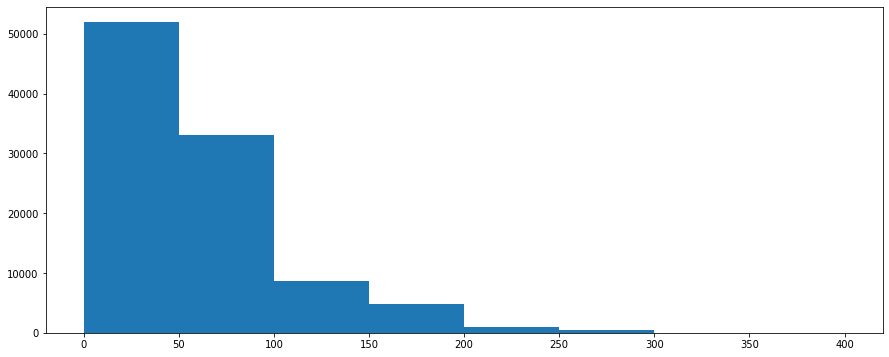

In [7]:
plt.hist(df_known.item_price, bins = 8, range = (0, 400))

Conclusions:
- Vast majority of orders is priced €200 or lower
- Slightly more than 50% of orders are priced €50 or lower
- Slightly more than 30% of orders are priced higher than €50 but lower than €100
- almost 10% of orders are priced between 100-150
- rest (~10%) of observations have price > 150

#### Correlation heatmap

In order to check how some features relate with each other at this point it would help to visualize the correlation between those features using seaborn:

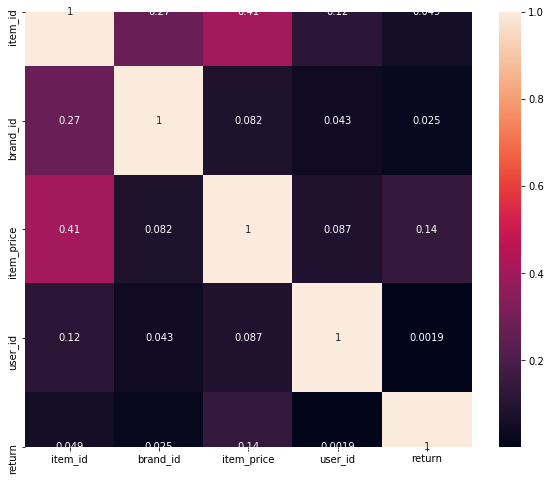

In [8]:
# sns correlation heatmap
fig, ax = plt.subplots(figsize=(10,8))
corr = df_known.corr()

sns.heatmap(corr,
            annot= True,
            xticklabels=corr.columns.values)

Conclusions:
- Highest correlation is observed between features item_price & return
- This can be interpreted as: possibility of an order to be returned is mostly related to its price, according to the analysis done so far.

The possibility that there is a single factor that can explain and correlates highly with return is excluded at this point.

---

## 3. Data Prep 

### 3.1 Convert data types

From analysis in part 2, it is to be concluded that some of the features are not assigned appropriate data type.

In [9]:
# Dates are to be converted to datetime data type in order to be able to make calculations

df_known["order_date"] = df_known["order_date"].astype("datetime64")
df_known["delivery_date"] = df_known["delivery_date"].astype("datetime64")
df_known["item_id"] = df_known["item_id"].astype("object")
df_known["brand_id"] = df_known["brand_id"].astype("object")
df_known["user_id"] = df_known["user_id"].astype("object")
df_known["user_dob"] = df_known["user_dob"].astype("datetime64")
df_known["user_reg_date"] = df_known["user_reg_date"].astype("datetime64")

df_known.dtypes

order_date       datetime64[ns]
delivery_date    datetime64[ns]
item_id                  object
item_size                object
item_color               object
brand_id                 object
item_price              float64
user_id                  object
user_title               object
user_dob         datetime64[ns]
user_state               object
user_reg_date    datetime64[ns]
return                    int64
dtype: object

### 3.2 Handle empty/nulls

As seen in part 2, columns delivery_date and user_dob have around 10% of the observations nulls:

In [15]:
print(df_known.isnull().sum())

order_date          0
delivery_date    9318
item_id             0
item_size           0
item_color          0
brand_id            0
item_price          0
user_id             0
user_title          0
user_dob         8725
user_state          0
user_reg_date       0
return              0
dtype: int64


In order to handle those null values we are going to **impute mean value** for those features, as to prevent data loss (Kumar, 2020)

In [16]:
# creating a copy of the dataframe to work on
df_known_2 = df_known.copy()

In [17]:
delivery_date_mean = df_known_2.delivery_date.mean()
user_dob_mean = df_known_2.user_dob.mean()

print(delivery_date_mean)
print(user_dob_mean)

2016-04-07 10:44:13.333464832
2041-05-05 07:12:29.817629952


In [18]:
df_known_2.delivery_date.fillna(delivery_date_mean, inplace = True)
df_known_2.user_dob.fillna(user_dob_mean, inplace = True)

No nulls remain in the dataset:

In [19]:
print(df_known_2.isnull().sum())

order_date       0
delivery_date    0
item_id          0
item_size        0
item_color       0
brand_id         0
item_price       0
user_id          0
user_title       0
user_dob         0
user_state       0
user_reg_date    0
return           0
dtype: int64


### 3.3 Handle outliers

As per analysis in part 2, several features have outliers:

In [20]:
print(df_known_2.max(), df_known_2.min(), sep = "\n\n")

order_date       2016-12-08 00:00:00
delivery_date    2017-01-24 00:00:00
item_id                         2241
item_size                       xxxl
item_color                    yellow
brand_id                         138
item_price                       999
user_id                        48241
user_title              not reported
user_dob         2070-12-31 00:00:00
user_state                 Thuringia
user_reg_date    2016-12-09 00:00:00
return                             1
dtype: object

order_date       2016-01-07 00:00:00
delivery_date    1994-12-31 00:00:00
item_id                            1
item_size                          1
item_color                         ?
brand_id                           1
item_price                         0
user_id                            9
user_title                   Company
user_dob         1971-01-01 00:00:00
user_state        Baden-Wuerttemberg
user_reg_date    2015-01-03 00:00:00
return                             0
dtype: object


Specifically, the following columns present necessity to handle outlying values:
- delivery_date
- user_dob

In order to handle outliers in our dataset, we are going to truncate the dataset to keep only the values that are within IQR

In [21]:
# function to handle outliers within IQR
def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a contant value equal to the IQR
    times a factor, which, following Tuckey's rule, we set to 1.5 by default
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

In [22]:
delivery_date_new = outlier_truncation(df_known_2.delivery_date.astype(np.int64)) # convert to int to make function possible to use
user_dob_new = outlier_truncation(df_known_2.user_dob.astype(np.int64)) # convert to int to make function possible to use
order_date_new = outlier_truncation(df_known_2.order_date.astype(np.int64))

print(delivery_date_new)
print("\n")
print(user_dob_new)
print("\n")
print(order_date_new)

order_item_id
1         1466985600000000000
2         1460025853333464832
3         1466985600000000000
4         1466985600000000000
5         1466985600000000000
                 ...         
99996     1481241600000000000
99997     1481241600000000000
99998     1442458233333662208
99999     1442458233333662208
100000    1470787200000000000
Name: delivery_date, Length: 100000, dtype: int64


order_item_id
1         3133382400000000000
2         3133382400000000000
3         3165350400000000000
4         3165350400000000000
5         3165350400000000000
                 ...         
99996     2815430400000000000
99997     2815430400000000000
99998     1132034474544074880
99999     1132034474544074880
100000    1132034474544074880
Name: user_dob, Length: 100000, dtype: int64


order_item_id
1         1466553600000000000
2         1466553600000000000
3         1466553600000000000
4         1466553600000000000
5         1466553600000000000
                 ...         
99996     147864960

In [23]:
# assigning the new columns back to the dataframe
df_known_2["delivery_date"] = delivery_date_new.astype("datetime64[ns]")
df_known_2["user_dob"] = user_dob_new.astype("datetime64[ns]")
df_known_2["order_date"] = order_date_new.astype("datetime64[ns]")

Now min/max values for the selected columsn are adjusted accordingly:

In [24]:
print(df_known_2.max(), df_known_2.min(), sep = "\n\n")

order_date       2016-12-07 12:00:00
delivery_date    2017-01-24 00:00:00
item_id                         2241
item_size                       xxxl
item_color                    yellow
brand_id                         138
item_price                       999
user_id                        48241
user_title              not reported
user_dob         2070-12-31 00:00:00
user_state                 Thuringia
user_reg_date    2016-12-09 00:00:00
return                             1
dtype: object

order_date                 2016-02-19 12:00:00
delivery_date    2015-09-17 02:50:33.333662208
item_id                                      1
item_size                                    1
item_color                                   ?
brand_id                                     1
item_price                                   0
user_id                                      9
user_title                             Company
user_dob         2005-11-15 06:01:14.544074880
user_state                  Baden-

### 3.4 Feature recategorization

#### item_size

Feature item_size contains many different values, text or numbers as text. It is better to handle those different values to be able to make some meaning and use the feature for the analysis. In this regards, all different values will befitted for item_size into xs-xl proportionally:

In [26]:
item_size = df_known_2.item_size

In [27]:
# what values exist in item_size
np.sort(item_size.unique())

array(['1', '10', '10+', '100', '104', '105', '11', '11+', '116', '12',
       '12+', '128', '13', '14', '140', '152', '164', '176', '18', '19',
       '2', '2+', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '3+', '30', '31', '3132', '32', '33', '3332', '34',
       '3432', '35', '36', '36+', '3632', '3634', '37', '37+', '38',
       '38+', '3832', '3834', '39', '39+', '4', '4+', '40', '40+', '4032',
       '4034', '41', '41+', '42', '42+', '43', '43+', '44', '44+', '45',
       '45+', '46', '46+', '47', '48', '49', '5', '5+', '50', '52', '54',
       '56', '58', '6', '6+', '7', '7+', '8', '8+', '80', '84', '9', '9+',
       '90', 'l', 'm', 's', 'unsized', 'xl', 'xs', 'xxl', 'xxxl'],
      dtype=object)

Recategorising as follows:

In [28]:
# recategorizing is done in an empirical-manual way to reduce number of categories

# recategorize xxl and xxxl into xl
item_size = item_size.replace(["xxl", "xxxl"], "xl", inplace = False)

# all other numerical sizes into this categories
item_size = item_size.replace(["1", "1+", "2", "2+", "3", "3+"], "xs", inplace = False)
item_size = item_size.replace(["4", "4+", "5", "5+", "6", "6+"], "s", inplace = False)
item_size = item_size.replace(["7", "7+", "8", "8+", "9", "9+"], "m", inplace = False)
item_size = item_size.replace(["10", "10+", "11", "11+"], "l", inplace = False)
item_size = item_size.replace(["12", "12+", "13", "14"], "xl", inplace = False)

item_size = item_size.replace(["100", "104"], "xs", inplace = False)
item_size = item_size.replace(["105", "116"], "s", inplace = False)
item_size = item_size.replace(["128", "140"], "m", inplace = False)
item_size = item_size.replace(["152", "164"], "l", inplace = False)
item_size = item_size.replace(["176"], "xl", inplace = False)

item_size = item_size.replace(["18", "19", "20", "21", "22", "23"], "xs", inplace = False)
item_size = item_size.replace(["24", "25", "26", "27", "28", "29"], "s", inplace = False)
item_size = item_size.replace(["30", "31", "32", "33", "34", "35", "36", "36+", "37", "37+", "38", "38+", "39", "39+"], "m", inplace = False)
item_size = item_size.replace(["40", "40+", "41", "41+", "42", "42+", "43", "43+", "44", "44+", "45", "45+"], "l", inplace = False)
item_size = item_size.replace(["46", "46+", "47", "48", '49', '50', '52', '54', '56', "58", "80", "84", "90"], "xl", inplace = False)

item_size = item_size.replace(['3132', '3332'], "xs", inplace = False)
item_size = item_size.replace(['3432', '3632'], "s", inplace = False)
item_size = item_size.replace(['3634', '3832'], "m", inplace = False)
item_size = item_size.replace(['3834'], "l", inplace = False)
item_size = item_size.replace(['4032', '4034'], "xl", inplace = False)

# we treat "unsized" as null and replace with mode value:
item_size = item_size.replace(["unsized"], item_size.mode(), inplace = False)

In [29]:
# let's check once again our values are all xs-sl:
np.sort(item_size.unique())

array(['l', 'm', 's', 'xl', 'xs'], dtype=object)

In [30]:
# assign the values we have calculated to the dataframe
df_known_2["item_size"] = item_size
df_known_2["item_size"]

order_item_id
1          m
2          l
3         xl
4         xl
5         xl
          ..
99996     xs
99997     xs
99998     xl
99999     xl
100000     s
Name: item_size, Length: 100000, dtype: object

### 3.5 Feature creation

#### Delivery duration

Goal is to examine the relation between delivery duration and returns, going to create a new column named **delivery_duration** that calculates the difference between order_date and delivery_date:

In [31]:
delivery_duration = df_known_2["delivery_date"] - df_known_2["order_date"]
delivery_duration = delivery_duration.astype("int64")
delivery_duration

order_item_id
1           432000000000000
2         -6527746666535168
3           432000000000000
4           432000000000000
5           432000000000000
                ...        
99996      2592000000000000
99997      2592000000000000
99998    -36191366666337792
99999    -36191366666337792
100000    -7862400000000000
Length: 100000, dtype: int64

In [32]:
# Remove outliers from the new feature
delivery_duration = outlier_truncation(delivery_duration.astype("int64"))
delivery_duration

order_item_id
1           432000000000000
2         -6527746666535168
3           432000000000000
4           432000000000000
5           432000000000000
                ...        
99996      2592000000000000
99997      2592000000000000
99998    -16171580000197248
99999    -16171580000197248
100000    -7862400000000000
Length: 100000, dtype: int64

In [141]:
delivery_duration = np.where(delivery_duration <= 0, 0, delivery_duration) # imput 0 to outlying values

In [34]:
# assign from variable to dataframe column
df_known_2["delivery_duration"] = delivery_duration 

# convert to int with number of days
df_known_2["delivery_duration"] = df_known_2["delivery_duration"].astype("timedelta64[ns]").dt.days

Now dataset looks like this:

In [35]:
df_known_2

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return,delivery_duration
order_item_id,,,,,,,,,,,,,,
1,2016-06-22,2016-06-27 00:00:00.000000000,643,m,navy,30,49.90,30822,Mrs,2069-04-17 00:00:00.000000000,Saxony,2016-06-23,0,5
2,2016-06-22,2016-04-07 10:44:13.333464832,337,l,grey,30,19.95,30822,Mrs,2069-04-17 00:00:00.000000000,Saxony,2016-06-23,0,0
3,2016-06-22,2016-06-27 00:00:00.000000000,270,xl,grey,49,79.90,30823,Mrs,2070-04-22 00:00:00.000000000,Baden-Wuerttemberg,2015-03-15,1,5
4,2016-06-22,2016-06-27 00:00:00.000000000,142,xl,grey,49,99.90,30823,Mrs,2070-04-22 00:00:00.000000000,Baden-Wuerttemberg,2015-03-15,0,5
5,2016-06-22,2016-06-27 00:00:00.000000000,561,xl,grey,3,14.90,30823,Mrs,2070-04-22 00:00:00.000000000,Baden-Wuerttemberg,2015-03-15,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,2016-11-09,2016-12-09 00:00:00.000000000,156,xs,blue,34,29.90,713,Mrs,2059-03-21 00:00:00.000000000,Rhineland-Palatinate,2015-02-17,0,30
99997,2016-11-09,2016-12-09 00:00:00.000000000,156,xs,brown,34,29.90,713,Mrs,2059-03-21 00:00:00.000000000,Rhineland-Palatinate,2015-02-17,0,30
99998,2016-11-09,2015-09-17 02:50:33.333662208,1832,xl,black,37,26.90,47794,Mr,2005-11-15 06:01:14.544074880,Hamburg,2016-10-09,0,0


#### user_age

In [36]:
from datetime import date
today = date.today()
today

datetime.date(2021, 4, 30)

In [37]:
df_known_2['user_dob'] = df_known_2['user_dob'] - pd.DateOffset(years=100)

df_known_2['user_dob']

order_item_id
1        1969-04-17 00:00:00.000000000
2        1969-04-17 00:00:00.000000000
3        1970-04-22 00:00:00.000000000
4        1970-04-22 00:00:00.000000000
5        1970-04-22 00:00:00.000000000
                      ...             
99996    1959-03-21 00:00:00.000000000
99997    1959-03-21 00:00:00.000000000
99998    1905-11-15 06:01:14.544074880
99999    1905-11-15 06:01:14.544074880
100000   1905-11-15 06:01:14.544074880
Name: user_dob, Length: 100000, dtype: datetime64[ns]

In [38]:
user_age = pd.Timestamp.now() - df_known_2["user_dob"]
user_age

order_item_id
1        19006 days 20:50:36.734200
2        19006 days 20:50:36.734200
3        18636 days 20:50:36.734200
4        18636 days 20:50:36.734200
5        18636 days 20:50:36.734200
                    ...            
99996    22686 days 20:50:36.734200
99997    22686 days 20:50:36.734200
99998    42170 days 14:49:22.190125
99999    42170 days 14:49:22.190125
100000   42170 days 14:49:22.190125
Name: user_dob, Length: 100000, dtype: timedelta64[ns]

In [39]:
# assign to dataframe
df_known_2["user_age"] = user_age

### 3.6. Feature normalization

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
# convert to numpy array in order to normalize
order_date = df_known_2["order_date"].to_numpy().reshape(-1,1)
delivery_date = df_known_2["delivery_date"].to_numpy().reshape(-1,1)
item_price = df_known_2["item_price"].to_numpy().reshape(-1,1)
user_dob = df_known_2["user_dob"].to_numpy().reshape(-1,1)
user_reg_date = df_known_2["user_reg_date"].to_numpy().reshape(-1,1)
delivery_duration = df_known_2["delivery_duration"].to_numpy().reshape(-1,1)
user_age = df_known_2["user_age"].to_numpy().reshape(-1,1)

In [42]:
# create a blank dict to enter the scaler objects
scalers = {}

In [43]:
# function to create the scaler objects
def normalize(attr):
    scaler = MinMaxScaler(copy = False)
    scaler.fit(attr)
    attr_new = scaler.transform(attr)
    return scaler, attr_new

In [44]:
scalers["order_date"], order_date = normalize(order_date)
scalers["delivery_date"], delivery_date = normalize(delivery_date)
scalers["item_price"], item_price = normalize(item_price)
scalers["user_dob"], user_dob = normalize(user_dob)
scalers["user_reg_date"], user_reg_date = normalize(user_reg_date)
scalers["delivery_duration"], delivery_duration = normalize(delivery_duration)
scalers["user_age"], user_age = normalize(user_age)

scalers

{'order_date': MinMaxScaler(copy=False, feature_range=(0, 1)),
 'delivery_date': MinMaxScaler(copy=False, feature_range=(0, 1)),
 'item_price': MinMaxScaler(copy=False, feature_range=(0, 1)),
 'user_dob': MinMaxScaler(copy=False, feature_range=(0, 1)),
 'user_reg_date': MinMaxScaler(copy=False, feature_range=(0, 1)),
 'delivery_duration': MinMaxScaler(copy=False, feature_range=(0, 1)),
 'user_age': MinMaxScaler(copy=False, feature_range=(0, 1))}

In [45]:
# assign the normalized columns to new columns in the dataset
df_known_2["order_date_norm"] = order_date
df_known_2["delivery_date_norm"] = delivery_date
df_known_2["item_price_norm"] = item_price
df_known_2["user_dob_norm"] = user_dob
df_known_2["user_reg_date_norm"] = user_reg_date
df_known_2["delivery_duration_norm"] = delivery_duration
df_known_2["user_age_norm"] = user_age

df_known_2

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,...,return,delivery_duration,user_age,order_date_norm,delivery_date_norm,item_price_norm,user_dob_norm,user_reg_date_norm,delivery_duration_norm,user_age_norm
order_item_id,,,,,,,,,,,,,,,,,,,,,
1,2016-06-22,2016-06-27 00:00:00.000000000,643,m,navy,30,0.049950,30822,Mrs,1969-04-17 00:00:00.000000000,...,0,5,19006 days 20:50:36.734200,0.422945,0.573635,0.049950,0.973809,0.760623,0.030864,0.026191
2,2016-06-22,2016-04-07 10:44:13.333464832,337,l,grey,30,0.019970,30822,Mrs,1969-04-17 00:00:00.000000000,...,0,0,19006 days 20:50:36.734200,0.422945,0.410864,0.019970,0.973809,0.760623,0.000000,0.026191
3,2016-06-22,2016-06-27 00:00:00.000000000,270,xl,grey,49,0.079980,30823,Mrs,1970-04-22 00:00:00.000000000,...,1,5,18636 days 20:50:36.734200,0.422945,0.573635,0.079980,0.989364,0.100567,0.030864,0.010636
4,2016-06-22,2016-06-27 00:00:00.000000000,142,xl,grey,49,0.100000,30823,Mrs,1970-04-22 00:00:00.000000000,...,0,5,18636 days 20:50:36.734200,0.422945,0.573635,0.100000,0.989364,0.100567,0.030864,0.010636
5,2016-06-22,2016-06-27 00:00:00.000000000,561,xl,grey,3,0.014915,30823,Mrs,1970-04-22 00:00:00.000000000,...,1,5,18636 days 20:50:36.734200,0.422945,0.573635,0.014915,0.989364,0.100567,0.030864,0.010636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,2016-11-09,2016-12-09 00:00:00.000000000,156,xs,blue,34,0.029930,713,Mrs,1959-03-21 00:00:00.000000000,...,0,30,22686 days 20:50:36.734200,0.902397,0.907048,0.029930,0.819101,0.063739,0.185185,0.180899
99997,2016-11-09,2016-12-09 00:00:00.000000000,156,xs,brown,34,0.029930,713,Mrs,1959-03-21 00:00:00.000000000,...,0,30,22686 days 20:50:36.734200,0.902397,0.907048,0.029930,0.819101,0.063739,0.185185,0.180899
99998,2016-11-09,2015-09-17 02:50:33.333662208,1832,xl,black,37,0.026927,47794,Mr,1905-11-15 06:01:14.544074880,...,0,0,42170 days 14:49:22.190125,0.902397,0.000000,0.026927,0.000000,0.913598,0.000000,1.000000


### 3.7 Category encoding (One-hot encoding)

Onehot encoder module for categorical values. To be applied for 
- user_title
- item_color
- user_state
- brand_id

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
# creating function to use the module

def ohe(col):
    """ One hot encoder function
    col = column name string
    
    returns multidim array
    """
    enc = OneHotEncoder(handle_unknown = "ignore")
    col = df_known_2[col].to_numpy().reshape(-1,1)
    enc.fit(col)
    return enc.transform(col).toarray()

In [48]:
# user_title

user_title_ohe = ohe("user_title")
print(user_title_ohe, user_title_ohe.shape, sep = "\n\n")

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]

(100000, 5)


In [49]:
# user_state

user_state_ohe = ohe("user_state")
print(user_state_ohe, user_state_ohe.shape, sep = "\n\n")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

(100000, 16)


In [50]:
# item_color

item_color_ohe = ohe("item_color")
print(item_color_ohe, item_color_ohe.shape, sep = "\n\n")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

(100000, 77)


In [51]:
# brand_id

brand_id_ohe = ohe("brand_id")
print(brand_id_ohe, brand_id_ohe.shape, sep = "\n\n")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

(100000, 135)


In [52]:
# before we append our OHE tables to our dataframe, we create a copy as it is a major change to the structure

df_known_3 = df_known_2.copy()

In [53]:
def ohe_to_column(df, attribute_ohe, prefix):
    df_attribute_ohe = pd.DataFrame(attribute_ohe, columns = [prefix + str(i + 1) for i in range(attribute_ohe.shape[1])])
    df_attribute_ohe.index += 1
    df = pd.merge(df, df_attribute_ohe, left_index=True, right_index=True, how="outer")
    return df

In [136]:
df_known_3 = ohe_to_column(df_known_3, user_title_ohe, "user_title_")

In [137]:
df_known_3 = ohe_to_column(df_known_3, user_state_ohe, "user_state_")

In [138]:
df_known_3 = ohe_to_column(df_known_3, item_color_ohe, "item_color_")

In [139]:
df_known_3 = ohe_to_column(df_known_3, brand_id_ohe, "brand_id_")

In [140]:
df_known_3

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,...,brand_id_126_y,brand_id_127_y,brand_id_128_y,brand_id_129_y,brand_id_130_y,brand_id_131_y,brand_id_132_y,brand_id_133_y,brand_id_134_y,brand_id_135_y
order_item_id,,,,,,,,,,,,,,,,,,,,,
1,2016-06-22,2016-06-27 00:00:00.000000000,643,m,navy,30,0.049950,30822,Mrs,1969-04-17 00:00:00.000000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-06-22,2016-04-07 10:44:13.333464832,337,l,grey,30,0.019970,30822,Mrs,1969-04-17 00:00:00.000000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-06-22,2016-06-27 00:00:00.000000000,270,xl,grey,49,0.079980,30823,Mrs,1970-04-22 00:00:00.000000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-06-22,2016-06-27 00:00:00.000000000,142,xl,grey,49,0.100000,30823,Mrs,1970-04-22 00:00:00.000000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-06-22,2016-06-27 00:00:00.000000000,561,xl,grey,3,0.014915,30823,Mrs,1970-04-22 00:00:00.000000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,2016-11-09,2016-12-09 00:00:00.000000000,156,xs,blue,34,0.029930,713,Mrs,1959-03-21 00:00:00.000000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99997,2016-11-09,2016-12-09 00:00:00.000000000,156,xs,brown,34,0.029930,713,Mrs,1959-03-21 00:00:00.000000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99998,2016-11-09,2015-09-17 02:50:33.333662208,1832,xl,black,37,0.026927,47794,Mr,1905-11-15 06:01:14.544074880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


---

## 4. Model Tuning and Selection

In order to pinpoint which model best fits the data, different **classification models** need to be tried out. In this case, the following models are going to be tested:
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machine

To fine-tune each model, going to experiment with inserting normalised features, encoded features or both. Scores will be insered in dictionary for later comparison. Comparison criteria is going to be AUC (area under curve) score.

### 4.1 Define list of features to test

In [58]:
# Create list with OHE columns to imput into different functions
ohe_columns = list( set(df_known_3.columns).difference(set(df_known_2.columns)) )

# Create list with normalised columns
norm_columns = ['order_date_norm', 'delivery_date_norm', 'item_price_norm', 'user_dob_norm', 
                'user_reg_date_norm', 'delivery_duration_norm']

### 4.2 Define dependent and independent variables

In [59]:
# Define y (target)
y = df_known_3["return"]

# Define X as set of normalized features for now
X = df_known_3[norm_columns]

### 4.3 Split sample

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
# The known dataset is to be split into train and test part with a 70-30 ratio.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 888)

In [62]:
# confirm it works
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(70000, 6) (30000, 6)
(70000,) (30000,)


### 4.4 Define functions for testing models using AUC score

In [81]:
def auc_score_for_model(model, hyp_param, features, no_of_rows = 100000):
    """ Function that takes model and parameter as input and returns maximum auc
    score for the model
    
    model: name of model to test as string
    hyp_param: list of possible values to test for model hyp.param
    
    no_of_rows: number of rows to be included in sample (option to use less rows
    in case model too slow)

    return: max_auc_score, parameter value for auc max

    """
    max_auc_score = -1
    max_hyp_param = None
    
    y = df_known_3["return"].head(no_of_rows)
    X = df_known_3[features].head(no_of_rows)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 888)
    
    for val in hyp_param:
        if model == "Logistic Regression":
            model = LogisticRegression(fit_intercept = True, C=val)
        elif model == "Decision Tree":
            model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=val)
        elif model == "Random Forest":
            model = RandomForestClassifier(n_estimators=val)
        elif model == "Support Vector Machine":
            model = SVC(C=val, probability=True) # default kernel rbf ok
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        auc_score = roc_auc_score(y_test, y_predict)
        if auc_score > max_auc_score:
            max_auc_score = auc_score
            max_hyp_param = val
            # calculation to be used in the visualisation of ROC curve
            probs = model.predict_proba(X_test)
            preds = probs[:,1]
            fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
            roc_auc = metrics.auc(fpr, tpr)
#         print(auc_score, val)
#     print(max_auc_score, max_hyp_param)
    return (max_auc_score, max_hyp_param, fpr, tpr, roc_auc)

In [82]:
# define dict to save model max auc scores
max_model_auc_scores = {"Logistic Regression": 0,
          "Decision Tree": 0,
          "Random Forest": 0,
          "Support Vector Machine": 0}

In [83]:
# dicts to save fpr, tpr, roc_auch values for visualisation
max_fpr = {"Logistic Regression": 0,
          "Decision Tree": 0,
          "Random Forest": 0,
          "Support Vector Machine": 0}

max_tpr = {"Logistic Regression": 0,
          "Decision Tree": 0,
          "Random Forest": 0,
          "Support Vector Machine": 0}

max_roc_auc = {"Logistic Regression": 0,
          "Decision Tree": 0,
          "Random Forest": 0,
          "Support Vector Machine": 0}

In [84]:
def save_max_auc_score(model_tested, auc_score):
    """ Function to insert max auch score of model to dict
    
    return: update dict
    """
    if max_model_auc_scores[model_tested] < auc_score:
        max_model_auc_scores[model_tested] = round(auc_score, 3)
    return max_model_auc_scores

### 4.5 Logistic Regression

First model to be tested is logistic regression. As the predicted variable is classification (0 or 1), we choose logistic instread of linear regression.

In [85]:
import statsmodels.api as sm
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_auc_score

In [86]:
# Test logistic regression with different values for c
model_tested = "Logistic Regression"
C_values = [100, 10, 1.0, 0.1, 0.01]

# test for norm features
max_auc_score_n, max_hyperparam_n, fpr_n, tpr_n, roc_auc_n = auc_score_for_model(model_tested, C_values, norm_columns)

# test for encoded features
max_auc_score_ohe, max_hyperparam_ohe, fpr_ohe, tpr_ohe, roc_auc_ohe = auc_score_for_model(model_tested, C_values, ohe_columns)

# test for for both norm & encoded features
max_auc_score_norm_nohe, max_hyperparam_norm_nohe, fpr_nohe, tpr_nohe, roc_auc_nohe = auc_score_for_model(model_tested, C_values, norm_columns+ohe_columns)

print("Max score for normalised features:", max_auc_score_n, max_hyperparam_n )
print("Max score for encoded features:", max_auc_score_ohe, max_hyperparam_ohe)
print("Max score for both normalised & encoded features:", max_auc_score_norm_nohe, max_hyperparam_norm_nohe)

Max score for normalised features: 0.5624951438130081 100
Max score for encoded features: 0.5621735035258013 100
Max score for both normalised & encoded features: 0.5913275068405857 100


In [87]:
# highest score is for using both normalised and encoded features
max_score = max(max_auc_score_n, max_auc_score_ohe, max_auc_score_norm_nohe)
save_max_auc_score(model_tested, max_score)

{'Logistic Regression': 0.591,
 'Decision Tree': 0,
 'Random Forest': 0,
 'Support Vector Machine': 0}

In [89]:
max_fpr[model_tested] = fpr_nohe
max_tpr[model_tested] = tpr_nohe
max_roc_auc[model_tested] = roc_auc_nohe

Changing the underlying dataset (X) does not affect logistic regression

### 4.6 Decision Tree

In [90]:
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [91]:
model_tested = "Decision Tree"
max_depths = [1, 2, 3, 4, 5]

# test for norm features
max_auc_score_n, max_hyperparam_n, fpr_n, tpr_n, roc_auc_n = auc_score_for_model(model_tested, max_depths, norm_columns)

# test for encoded features
max_auc_score_ohe, max_hyperparam_ohe, fpr_ohe, tpr_ohe, roc_auc_ohe = auc_score_for_model(model_tested, max_depths, ohe_columns)

# test for for both norm & encoded features
max_auc_score_norm_nohe, max_hyperparam_norm_nohe, fpr_nohe, tpr_nohe, roc_auc_nohe = auc_score_for_model(model_tested, max_depths, norm_columns+ohe_columns)

print("Max score for normalised features:", max_auc_score_n, max_hyperparam_n )
print("Max score for encoded features:", max_auc_score_ohe, max_hyperparam_ohe)
print("Max score for both normalised & encoded features:", max_auc_score_norm_nohe, max_hyperparam_norm_nohe)

Max score for normalised features: 0.5763206452929224 1
Max score for encoded features: 0.5 1
Max score for both normalised & encoded features: 0.5763206452929224 1


In [92]:
# highest score is for using only normalised features
max_score = max(max_auc_score_n, max_auc_score_ohe, max_auc_score_norm_nohe)
save_max_auc_score(model_tested, max_score)

{'Logistic Regression': 0.591,
 'Decision Tree': 0.576,
 'Random Forest': 0,
 'Support Vector Machine': 0}

In [93]:
max_fpr[model_tested] = fpr_n
max_tpr[model_tested] = tpr_n
max_roc_auc[model_tested] = roc_auc_n

### 4.7 Random Forest

In [135]:
from sklearn.ensemble import RandomForestClassifier

In [96]:
model_tested = "Random Forest"
n_estimators = [10, 100, 1000]

# test for norm features
max_auc_score_n, max_hyperparam_n, fpr_n, tpr_n, roc_auc_n = auc_score_for_model(model_tested, n_estimators, norm_columns)

# test for encoded features
max_auc_score_ohe, max_hyperparam_ohe, fpr_ohe, tpr_ohe, roc_auc_ohe = auc_score_for_model(model_tested, n_estimators, ohe_columns)

# test for for both norm & encoded features
max_auc_score_norm_nohe, max_hyperparam_norm_nohe, fpr_nohe, tpr_nohe, roc_auc_nohe = auc_score_for_model(model_tested, n_estimators, norm_columns+ohe_columns)

print("Max score for normalised features:", max_auc_score_n, max_hyperparam_n )
print("Max score for encoded features:", max_auc_score_ohe, max_hyperparam_ohe)
print("Max score for both normalised & encoded features:", max_auc_score_norm_nohe, max_hyperparam_norm_nohe)

Max score for normalised features: 0.6301970144581612 10
Max score for encoded features: 0.5558794938944803 1000
Max score for both normalised & encoded features: 0.6230626259464325 1000


In [97]:
# highest score is for using only normalised features

max_score = max(max_auc_score_n, max_auc_score_ohe, max_auc_score_norm_nohe)
save_max_auc_score(model_tested, max_score)

{'Logistic Regression': 0.591,
 'Decision Tree': 0.576,
 'Random Forest': 0.63,
 'Support Vector Machine': 0}

Random Forest looks like a better fit so far from both logistic regression and decision tree

In [98]:
max_fpr[model_tested] = fpr_n
max_tpr[model_tested] = tpr_n
max_roc_auc[model_tested] = roc_auc_n

### 4.8 Support Vector Machine

In [99]:
from sklearn.svm import SVC

As SVC takes a lot of time to process, we are using 10,000 lines sample for training the model

In [100]:
model_tested = "Support Vector Machine"
C_val = [100, 10, 1.0, 0.1, 0.01]

# we will use 10,000 rows with SVM as otherwise the model gets too slow
number_of_rows = 1000

# test for norm features
max_auc_score_n, max_hyperparam_n, fpr_n, tpr_n, roc_auc_n = auc_score_for_model(model_tested, C_val, norm_columns, no_of_rows = number_of_rows)

# test for encoded features
max_auc_score_ohe, max_hyperparam_ohe, fpr_ohe, tpr_ohe, roc_auc_ohe = auc_score_for_model(model_tested, C_val, ohe_columns, no_of_rows = number_of_rows)

# test for for both norm & encoded features
max_auc_score_norm_nohe, max_hyperparam_norm_nohe, fpr_nohe, tpr_nohe, roc_auc_nohe = auc_score_for_model(model_tested, C_val, norm_columns+ohe_columns, no_of_rows = number_of_rows)

print("Max score for normalised features:", max_auc_score_n, max_hyperparam_n )
print("Max score for encoded features:", max_auc_score_ohe, max_hyperparam_ohe)
print("Max score for both normalised & encoded features:", max_auc_score_norm_nohe, max_hyperparam_norm_nohe)

Max score for normalised features: 0.6063403781979978 100
Max score for encoded features: 0.5939933259176864 100
Max score for both normalised & encoded features: 0.5804226918798666 100


In order to find the best parameters only 1000 lines were used. With the sample it was found that best fit comes with C=100 and using only the normalised features. At this point the model is to be trained to get the actual AUC (running time >30 mins)

In [ ]:
# highest score is for using only normalised features

# use full dataset to train the model and get actual AUC score
#  if it takes too much time feel free to skip this part

max_auc_score_n, max_hyperparam_n, fpr_n, tpr_n, roc_auc_n = auc_score_for_model(model_tested, C_val, norm_columns, no_of_rows = number_of_rows)

In [101]:
max_score = max(max_auc_score_n, max_auc_score_ohe, max_auc_score_norm_nohe)
save_max_auc_score(model_tested, max_score)

{'Logistic Regression': 0.591,
 'Decision Tree': 0.576,
 'Random Forest': 0.63,
 'Support Vector Machine': 0.606}

In [102]:
max_fpr[model_tested] = fpr_n
max_tpr[model_tested] = tpr_n
max_roc_auc[model_tested] = roc_auc_n

---

## 5. Model Evaluation

In this section the different optimized models will be compared to each other to pick the best one fitting the known data using the **ROC Curve** criteria.

### 5.1 ROC Curve - AUC

In [103]:
max_model_auc_scores

{'Logistic Regression': 0.591,
 'Decision Tree': 0.576,
 'Random Forest': 0.63,
 'Support Vector Machine': 0.606}

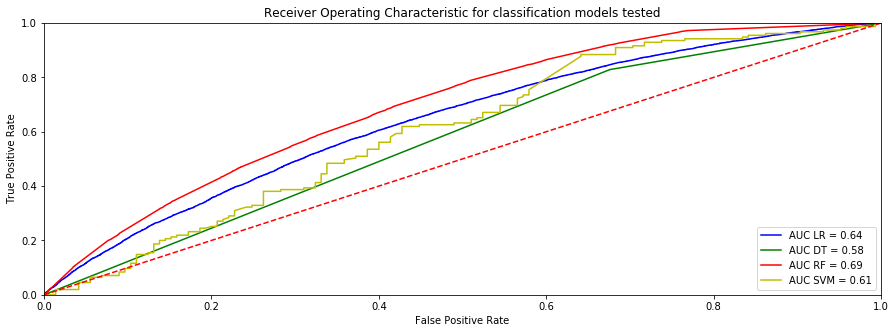

In [106]:
# plotting ROC curve for tested models

# as a different function was used to calculate AUC for the plot, the numbers deviate. However, the result is the same:
# Random forest is the best model to fit the data

plt.rcParams["figure.figsize"] = (15,5)
plt.title('Receiver Operating Characteristic for classification models tested')
plt.plot(max_fpr["Logistic Regression"], max_tpr["Logistic Regression"], 'b', label = 'AUC LR = %0.2f' % max_roc_auc["Logistic Regression"])
plt.plot(max_fpr["Decision Tree"], max_tpr["Decision Tree"], 'g', label = 'AUC DT = %0.2f' % max_roc_auc["Decision Tree"])
plt.plot(max_fpr["Random Forest"], max_tpr["Random Forest"], 'r', label = 'AUC RF = %0.2f' % max_roc_auc["Random Forest"])
plt.plot(max_fpr["Support Vector Machine"], max_tpr["Support Vector Machine"], 'y', label = 'AUC SVM = %0.2f' % max_roc_auc["Support Vector Machine"])
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Support Vector Machine produces the best predictions, so it should be used for creating the prediction

### 5.2 Create predictions for unkown dataset

#### Import unknown dataset & prepare data

In [107]:
df_unknown = pd.read_csv("BADS_WS2021_unknown.csv", index_col = 'order_item_id')

In [109]:
# 1 Convert data types
df_unknown["order_date"] = df_unknown["order_date"].astype("datetime64")
df_unknown["delivery_date"] = df_unknown["delivery_date"].astype("datetime64")
df_unknown["item_id"] = df_unknown["item_id"].astype("object")
df_unknown["brand_id"] = df_unknown["brand_id"].astype("object")
df_unknown["user_id"] = df_unknown["user_id"].astype("object")
df_unknown["user_dob"] = df_unknown["user_dob"].astype("datetime64")
df_unknown["user_reg_date"] = df_unknown["user_reg_date"].astype("datetime64")

In [111]:
# 2 Nulls
delivery_date_mean = df_unknown.delivery_date.mean()
user_dob_mean = df_unknown.user_dob.mean()
df_unknown.delivery_date.fillna(delivery_date_mean, inplace = True)
df_unknown.user_dob.fillna(user_dob_mean, inplace = True)

In [112]:
# 3 Outliers
delivery_date_new = outlier_truncation(df_unknown.delivery_date.astype(np.int64)) # convert to int to make function possible to use
user_dob_new = outlier_truncation(df_unknown.user_dob.astype(np.int64)) # convert to int to make function possible to use
order_date_new = outlier_truncation(df_unknown.order_date.astype(np.int64))

print(delivery_date_new)
print("\n")
print(user_dob_new)
print("\n")
print(order_date_new)

# assigning the new columns back to the dataframe
df_unknown["delivery_date"] = delivery_date_new.astype("datetime64[ns]")
df_unknown["user_dob"] = user_dob_new.astype("datetime64[ns]")
df_unknown["order_date"] = order_date_new.astype("datetime64[ns]")

order_item_id
100001    1484006400000000000
100002    1484006400000000000
100003    1484006400000000000
100004    1484006400000000000
100005    1484006400000000000
                 ...         
149996    1481587200000000000
149997    1481587200000000000
149998    1481587200000000000
149999    1481587200000000000
150000    1481587200000000000
Name: delivery_date, Length: 50000, dtype: int64


order_item_id
100001    -72230400000000000
100002    -72230400000000000
100003    -72230400000000000
100004    -72230400000000000
100005    -72230400000000000
                 ...        
149996   -178775593539327808
149997   -178775593539327808
149998   -178775593539327808
149999   -178775593539327808
150000    -68947200000000000
Name: user_dob, Length: 50000, dtype: int64


order_item_id
100001    1476489600000000000
100002    1476489600000000000
100003    1476489600000000000
100004    1476489600000000000
100005    1476489600000000000
                 ...         
149996    1481500800000000000
14

In [113]:
# 4 Recategorize

# recategorize xxl and xxxl into xl
item_size = item_size.replace(["xxl", "xxxl"], "xl", inplace = False)

# all other numerical sizes into this categories
item_size = item_size.replace(["1", "1+", "2", "2+", "3", "3+"], "xs", inplace = False)
item_size = item_size.replace(["4", "4+", "5", "5+", "6", "6+"], "s", inplace = False)
item_size = item_size.replace(["7", "7+", "8", "8+", "9", "9+"], "m", inplace = False)
item_size = item_size.replace(["10", "10+", "11", "11+"], "l", inplace = False)
item_size = item_size.replace(["12", "12+", "13", "14"], "xl", inplace = False)

item_size = item_size.replace(["100", "104"], "xs", inplace = False)
item_size = item_size.replace(["105", "116"], "s", inplace = False)
item_size = item_size.replace(["128", "140"], "m", inplace = False)
item_size = item_size.replace(["152", "164"], "l", inplace = False)
item_size = item_size.replace(["176"], "xl", inplace = False)

item_size = item_size.replace(["18", "19", "20", "21", "22", "23"], "xs", inplace = False)
item_size = item_size.replace(["24", "25", "26", "27", "28", "29"], "s", inplace = False)
item_size = item_size.replace(["30", "31", "32", "33", "34", "35", "36", "36+", "37", "37+", "38", "38+", "39", "39+"], "m", inplace = False)
item_size = item_size.replace(["40", "40+", "41", "41+", "42", "42+", "43", "43+", "44", "44+", "45", "45+"], "l", inplace = False)
item_size = item_size.replace(["46", "46+", "47", "48", '49', '50', '52', '54', '56', "58", "80", "84", "90"], "xl", inplace = False)

item_size = item_size.replace(['3132', '3332'], "xs", inplace = False)
item_size = item_size.replace(['3432', '3632'], "s", inplace = False)
item_size = item_size.replace(['3634', '3832'], "m", inplace = False)
item_size = item_size.replace(['3834'], "l", inplace = False)
item_size = item_size.replace(['4032', '4034'], "xl", inplace = False)

# we treat "unsized" as null and replace with mode value:
item_size = item_size.replace(["unsized"], item_size.mode(), inplace = False)

print(np.sort(item_size.unique()))

df_unknown["item_size"] = item_size

['l' 'm' 's' 'xl' 'xs']


order_item_id
100001    NaN
100002    NaN
100003    NaN
100004    NaN
100005    NaN
         ... 
149996    NaN
149997    NaN
149998    NaN
149999    NaN
150000    NaN
Name: item_size, Length: 50000, dtype: object

In [114]:
# 5 Feature Creation
delivery_duration = df_unknown["delivery_date"] - df_unknown["order_date"]
delivery_duration = delivery_duration.astype("int64")
delivery_duration

delivery_duration = outlier_truncation(delivery_duration.astype("int64"))
delivery_duration

delivery_duration = np.where(delivery_duration <= 0, 0, delivery_duration) # assign 0 temporarily to neg values

# assign from variable to dataframe column
df_unknown["delivery_duration"] = delivery_duration 

# convert to int with number of days
df_unknown["delivery_duration"] = df_unknown["delivery_duration"].astype("timedelta64[ns]").dt.days

from datetime import date
today = date.today()
today

df_unknown['user_dob'] = df_unknown['user_dob'] - pd.DateOffset(years=100)

df_unknown['user_dob']

user_age = pd.Timestamp.now() - df_unknown["user_dob"]
user_age

# assign to dataframe
df_unknown["user_age"] = user_age

In [115]:
# 6 Feat normalisation

# convert to numpy array in order to normalize
order_date = df_unknown["order_date"].to_numpy().reshape(-1,1)
delivery_date = df_unknown["delivery_date"].to_numpy().reshape(-1,1)
item_price = df_unknown["item_price"].to_numpy().reshape(-1,1)
user_dob = df_unknown["user_dob"].to_numpy().reshape(-1,1)
user_reg_date = df_unknown["user_reg_date"].to_numpy().reshape(-1,1)
delivery_duration = df_unknown["delivery_duration"].to_numpy().reshape(-1,1)
user_age = df_unknown["user_age"].to_numpy().reshape(-1,1)
# create a blank dict to enter the scaler objects
scalers = {}

scalers["order_date"], order_date = normalize(order_date)
scalers["delivery_date"], delivery_date = normalize(delivery_date)
scalers["item_price"], item_price = normalize(item_price)
scalers["user_dob"], user_dob = normalize(user_dob)
scalers["user_reg_date"], user_reg_date = normalize(user_reg_date)
scalers["delivery_duration"], delivery_duration = normalize(delivery_duration)
scalers["user_age"], user_age = normalize(user_age)
# assign the normalized columns to new columns in the dataset
df_unknown["order_date_norm"] = order_date
df_unknown["delivery_date_norm"] = delivery_date
df_unknown["item_price_norm"] = item_price
df_unknown["user_dob_norm"] = user_dob
df_unknown["user_reg_date_norm"] = user_reg_date
df_unknown["delivery_duration_norm"] = delivery_duration
df_unknown["user_age_norm"] = user_age


As it is already shown that best fit for random forest comes from using only the normalised features, it is not necessary to encode the categorical features for the unknown dataset.

## Merge known and unknown

In [124]:
# Creating the random forest classification for unknown dataset with optimal parameters:
# n_estimators = 100, use normalised columns only
model = RandomForestClassifier(n_estimators=100)

In [125]:
X = df_known_3[norm_columns]
y = df_known_3["return"]

In [126]:
# Fit whole known data
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [127]:
X_unknown = df_unknown[norm_columns]
X_unknown

,order_date_norm,delivery_date_norm,item_price_norm,user_dob_norm,user_reg_date_norm,delivery_duration_norm
order_item_id,,,,,,
100001,0.0,0.902027,0.174772,0.576785,0.912782,1.000000
100002,0.0,0.902027,0.174772,0.576785,0.912782,1.000000
100003,0.0,0.902027,0.174772,0.576785,0.912782,1.000000
100004,0.0,0.902027,0.124766,0.576785,0.912782,1.000000
100005,0.0,0.902027,0.149769,0.576785,0.912782,1.000000
...,...,...,...,...,...,...
149996,1.0,0.712838,0.224778,0.486563,0.000000,0.090909
149997,1.0,0.712838,0.042255,0.486563,0.000000,0.090909
149998,1.0,0.712838,0.199775,0.486563,0.000000,0.090909


In [128]:
model.predict(X_unknown)

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [131]:
y_unknown = model.predict(X_unknown)

In [133]:
df_predictions= pd.DataFrame(y_unknown, columns = ["return"])
df_predictions["order_item_id"] = df_unknown.index
columns_titles = ["order_item_id","return"]
df_predictions = df_predictions.reindex(columns=columns_titles)

df_predictions

,order_item_id,return
0,100001,1
1,100002,1
2,100003,1
3,100004,0
4,100005,1
...,...,...
49995,149996,1
49996,149997,0
49997,149998,0
49998,149999,0


### 5.3 Create output file

In [134]:
df_predictions.to_csv("616912.csv", sep=",", columns = ["order_item_id", "return"], mode = "w", index = False)

---

## 6. Conclusion

For this reason, for this classification problem the best results were returned with the random forests model, among other reasons because the results are uncorrelated (Yiu, 2019). Based on the random forest model the predictions were made. By creating accurate predictions of whether an order is returned or not the expected costs from returned are minimised, as the cases of false negatives and true positives are minimized, thus reducing the costs associated with those classes. Scaling this kind of modelling and predictions can save significant amounts to e-commerce shops, especially ones that handle thousands or millions of orders per day.

## References

Kumar S., 2020. 7 Ways to Handle Missing Values in Machine Learning

https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e  [accessed 30th of April 2021]

Yiu T., 2019. Understanding Random Forest [Online]:

https://towardsdatascience.com/understanding-random-forest-58381e0602d2 [accessed 30th of April 2021]